!pip install wordcloud
!pip install keras
!pip install transformers

In [2]:
#!pip install spacy
#!pip install transformers

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import string
import spacy



from spacy.lang.en import English
from spacy.tokens import Doc
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokenizer import Tokenizer


from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


from transformers import pipeline
from transformers import DistilBertModel,DistilBertTokenizer,TFDistilBertForTokenClassification

from torch.utils.data import dataloader,dataset

import wordcloud
from wordcloud import WordCloud,ImageColorGenerator

#LinearSVC,Logistic Regression,RandomForest,DecisionTree,KNeighborsClassifier
# Can use Distilbert https://towardsdatascience.com/use-pre-trained-huggingface-models-in-tensorflow-serving-d2761f7e69f6


In [4]:
wsb = pd.read_csv('/Users/jeremiahkamama/Desktop/Article Projects/Spacy-Analysis/data/reddit_wsb.csv')

wsb.head()

,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56


In [5]:
wsb.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47140 entries, 0 to 47139
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      47140 non-null  object 
 1   score      47140 non-null  int64  
 2   id         47140 non-null  object 
 3   url        47140 non-null  object 
 4   comms_num  47140 non-null  int64  
 5   created    47140 non-null  float64
 6   body       22090 non-null  object 
 7   timestamp  47140 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 2.9+ MB


In [6]:
#handling missing data
miss_val = wsb.isnull().sum()

miss_val[0:10]

title            0
score            0
id               0
url              0
comms_num        0
created          0
body         25050
timestamp        0
dtype: int64

In [7]:
cells = np.product(wsb.shape)
missing = miss_val.sum()

percentage_miss = (missing/cells)* 100

print(percentage_miss)

6.642448027153161


In [8]:
wsb.dropna()

,title,score,id,url,comms_num,created,body,timestamp
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
6,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE,317,l6uf6d,https://www.reddit.com/r/wallstreetbets/commen...,53,1.611862e+09,Hedgefund whales are spreading disinfo saying ...,2021-01-28 21:26:27
7,THIS IS THE MOMENT,405,l6ub9l,https://www.reddit.com/r/wallstreetbets/commen...,178,1.611862e+09,Life isn't fair. My mother always told me that...,2021-01-28 21:19:31
10,"We need to keep this movement going, we all ca...",222,l6uao1,https://www.reddit.com/r/wallstreetbets/commen...,70,1.611862e+09,I believe right now is one of those rare oppo...,2021-01-28 21:18:25
12,"Once you're done with GME - $AG and $SLV, the ...",0,l6u9wu,https://www.reddit.com/r/wallstreetbets/commen...,16,1.611861e+09,You guys are champs. GME... who would have tho...,2021-01-28 21:17:10
...,...,...,...,...,...,...,...,...
47129,FLGT Fulgent Genetics Earnings Record!,23,n6kpbv,https://www.reddit.com/r/wallstreetbets/commen...,23,1.620372e+09,I am long on FLGT! I think way too many people...,2021-05-07 10:22:34
47130,Anyone here in $PINS?,42,n6k9r9,https://www.reddit.com/r/wallstreetbets/commen...,31,1.620371e+09,Before you laugh at me just indulge me for a f...,2021-05-07 10:02:09
47131,Changes to Calls/Puts Open Interest Holdings W...,25,n6k7wf,https://www.reddit.com/r/wallstreetbets/commen...,9,1.620371e+09,How many total open interest calls were added...,2021-05-07 09:59:45
47133,Uranium DD,45,n6jqm0,https://www.reddit.com/r/wallstreetbets/commen...,59,1.620369e+09,TL:DR - Supply and demand fundamentals require...,2021-05-07 09:37:05


In [9]:
wsb.drop(columns=['id'])

,title,score,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56
...,...,...,...,...,...,...,...
47135,There is no crash coming for growth stocks - b...,175,https://www.reddit.com/r/wallstreetbets/commen...,144,1.620368e+09,"First off, yes I’m holding some heavy bags\n\n...",2021-05-07 09:21:30
47136,I give to you Roblox. Basically at it’s open p...,27,https://i.redd.it/gzqp34lhpkx61.jpg,144,1.620368e+09,NaN,2021-05-07 09:06:17
47137,$Baba about to put me in the streets 😓,69,https://i.redd.it/1bx2dxgqokx61.jpg,44,1.620367e+09,NaN,2021-05-07 09:01:37
47138,Is this enough ?,31,https://i.redd.it/fs95h1n8nkx61.jpg,24,1.620367e+09,NaN,2021-05-07 08:53:13


In [10]:
nlp = spacy.load("en_core_web_sm")

In [11]:
wsb_title = wsb['title'].dropna()

wsb_title = wsb_title.head(10)
print(wsb_title)

0    It's not about the money, it's about sending a...
1    Math Professor Scott Steiner says the numbers ...
2                                      Exit the system
3    NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...
4    Not to distract from GME, just thought our AMC...
5                                  WE BREAKING THROUGH
6          SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE
7                                   THIS IS THE MOMENT
8    Currently Holding AMC and NOK - Is it retarded...
9    I have nothing to say but BRUH I am speechless...
Name: title, dtype: object


In [35]:
title = nlp(wsb_title[1])
print(title)

Math Professor Scott Steiner says the numbers spell DISASTER for Gamestop shorts


In [13]:
for token in title:
    print(token.text,token.pos_,token.dep_)

Math PROPN compound
Professor PROPN compound
Scott PROPN compound
Steiner PROPN nsubj
says VERB ROOT
the DET det
numbers NOUN nsubj
spell VERB ccomp
DISASTER NOUN dobj
for ADP prep
Gamestop PROPN compound
shorts NOUN pobj


In [14]:
print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer']


In [38]:
wsb_body = wsb['body'].dropna()
wsb_body = wsb_body.head(10)
print(wsb_body)

2     The CEO of NASDAQ pushed to halt trading “to g...
6     Hedgefund whales are spreading disinfo saying ...
7     Life isn't fair. My mother always told me that...
10     I believe right now is one of those rare oppo...
12    You guys are champs. GME... who would have tho...
13    Firstly, all of you diamond hands and smooth-b...
19    Your daily trading discussion thread. Please k...
21    This is our time. If anyone will listen to you...
23    I still remember when I first joined and most ...
30                         https://youtu.be/BtjhgcAMYU0
Name: body, dtype: object


In [40]:
body_wsb = wsb_body[2]
print(body_wsb)

The CEO of NASDAQ pushed to halt trading “to give investors a chance to recalibrate their positions”.

[https://mobile.twitter.com/Mediaite/status/1354504710695362563](https://mobile.twitter.com/Mediaite/status/1354504710695362563)

Now SEC is investigating, brokers are disallowing buying more calls. This is the institutions flat out admitting they will change the rules to bail out the rich but if it happens to us, we get a “well shucks you should have known investing is risky! have you tried cutting out avocados and coffee, maybe doing Uber on the side?”

We may have collectively driven up enough sentiment in wall street to make other big players go long on GME with us (we do not have the money to move the stock as much as it did alone). we didn’t hurt wall street as a whole, just a few funds went down while others went up and profited off the shorts the same as us. The media wants to pin the blame on us.

It should be crystal clear that this is a rigged game by now. Its time to build

In [17]:


def clean_text(text):
    text = text.lower()

    # Replacing Handlers with Empty String
    text = re.sub('@[^\s]+','',text)

    # Replacing URLs with Empty String
    text = re.sub(r"http\S+", "",text)

    # Remove all the special characters
    text = ' '.join(re.findall(r'\w+', text))

    # Replacing Single Characters with Empty String
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # Removing Extra Spaces
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    return text
 

In [18]:
body = clean_text(body_wsb)
print(body)

the ceo of nasdaq pushed to halt trading to give investors chance to recalibrate their positions now sec is investigating brokers are disallowing buying more calls this is the institutions flat out admitting they will change the rules to bail out the rich but if it happens to us we get well shucks you should have known investing is risky have you tried cutting out avocados and coffee maybe doing uber on the side we may have collectively driven up enough sentiment in wall street to make other big players go long on gme with us we do not have the money to move the stock as much as it did alone we didn hurt wall street as whole just few funds went down while others went up and profited off the shorts the same as us the media wants to pin the blame on us it should be crystal clear that this is rigged game by now its time to build new exchanges that can arbitrarily change the rules on us cr has some version of these maybe they can be repurposed to be trade stock without government intervent

In [19]:
body_wsb = nlp(body)
print(body_wsb)

the ceo of nasdaq pushed to halt trading to give investors chance to recalibrate their positions now sec is investigating brokers are disallowing buying more calls this is the institutions flat out admitting they will change the rules to bail out the rich but if it happens to us we get well shucks you should have known investing is risky have you tried cutting out avocados and coffee maybe doing uber on the side we may have collectively driven up enough sentiment in wall street to make other big players go long on gme with us we do not have the money to move the stock as much as it did alone we didn hurt wall street as whole just few funds went down while others went up and profited off the shorts the same as us the media wants to pin the blame on us it should be crystal clear that this is rigged game by now its time to build new exchanges that can arbitrarily change the rules on us cr has some version of these maybe they can be repurposed to be trade stock without government intervent

In [20]:
token_list = []

for token in body_wsb:
    token_list.append(token.text)

filter_sentence = []

for word in token_list:
    lexeme = nlp.vocab[word]
    if lexeme.is_stop == False:
        filter_sentence.append(word)

print(token_list)


['the', 'ceo', 'of', 'nasdaq', 'pushed', 'to', 'halt', 'trading', 'to', 'give', 'investors', 'chance', 'to', 'recalibrate', 'their', 'positions', 'now', 'sec', 'is', 'investigating', 'brokers', 'are', 'disallowing', 'buying', 'more', 'calls', 'this', 'is', 'the', 'institutions', 'flat', 'out', 'admitting', 'they', 'will', 'change', 'the', 'rules', 'to', 'bail', 'out', 'the', 'rich', 'but', 'if', 'it', 'happens', 'to', 'us', 'we', 'get', 'well', 'shucks', 'you', 'should', 'have', 'known', 'investing', 'is', 'risky', 'have', 'you', 'tried', 'cutting', 'out', 'avocados', 'and', 'coffee', 'maybe', 'doing', 'uber', 'on', 'the', 'side', 'we', 'may', 'have', 'collectively', 'driven', 'up', 'enough', 'sentiment', 'in', 'wall', 'street', 'to', 'make', 'other', 'big', 'players', 'go', 'long', 'on', 'gme', 'with', 'us', 'we', 'do', 'not', 'have', 'the', 'money', 'to', 'move', 'the', 'stock', 'as', 'much', 'as', 'it', 'did', 'alone', 'we', 'didn', 'hurt', 'wall', 'street', 'as', 'whole', 'just', '

In [21]:
print(filter_sentence)

['ceo', 'nasdaq', 'pushed', 'halt', 'trading', 'investors', 'chance', 'recalibrate', 'positions', 'sec', 'investigating', 'brokers', 'disallowing', 'buying', 'calls', 'institutions', 'flat', 'admitting', 'change', 'rules', 'bail', 'rich', 'happens', 'shucks', 'known', 'investing', 'risky', 'tried', 'cutting', 'avocados', 'coffee', 'maybe', 'uber', 'collectively', 'driven', 'sentiment', 'wall', 'street', 'big', 'players', 'long', 'gme', 'money', 'stock', 'didn', 'hurt', 'wall', 'street', 'funds', 'went', 'went', 'profited', 'shorts', 'media', 'wants', 'pin', 'blame', 'crystal', 'clear', 'rigged', 'game', 'time', 'build', 'new', 'exchanges', 'arbitrarily', 'change', 'rules', 'cr', 'version', 'maybe', 'repurposed', 'trade', 'stock', 'government', 'intervention', 'don', 'know', 'exactly', 'look', 'like', 'broad', 'steps', '1', 'exit', 'current', 'financial', 'system', '2', 'build', 'new']


In [22]:
desc_stopwords = set(STOP_WORDS)

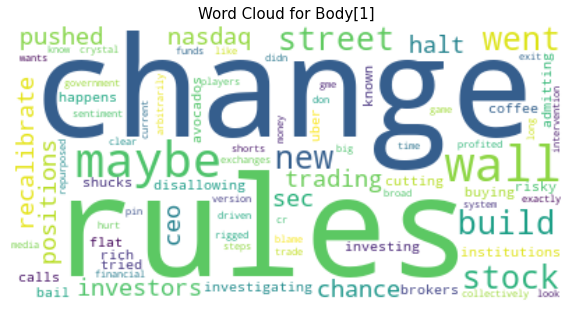

In [23]:
word_cloud = WordCloud(background_color="white", stopwords=desc_stopwords).generate(body)

plt.figure(figsize=(10,20))
plt.imshow(word_cloud,interpolation= 'bilinear')
plt.title("Word Cloud for Body[1]",fontsize=15)
plt.axis("off")
plt.show()


In [24]:


#def train_model(

#      model = Sequential(),
#      model.add(Embedding(max_features)),
#      model.add(Dense(2,activation='softmax')),
#      model.compile(loss='categorical_crossentropy',optimizer='adam',metric =['accuracy'])
#)

# print(model.summary())

 



In [36]:
sentiment_analysis = pipeline("sentiment-analysis")



In [26]:
result = sentiment_analysis(body)
print("Label:", result)
print("Confidence Score:",result)


Label: [{'label': 'NEGATIVE', 'score': 0.9993441700935364}]
Confidence Score: [{'label': 'NEGATIVE', 'score': 0.9993441700935364}]


In [42]:
print(wsb_body[6])

Hedgefund whales are spreading disinfo saying Friday is make-or-break for $GME. Call options expiring ITM on Friday will drive the price up if levels are maintained, but may not trigger the short squeeze.

It may be Friday, but it could be next week the we see the real squeeze.

DON'T PANIC IF THE SQUEEZE DOESN'T HAPPEN FRIDAY.

It's not guaranteed to. The only thing that is guaranteed mathematically is that the shorts will have to cover at some point in the future. They are trying to get enough people hooked on the false expectation of Friday so that if/when it doesn't happen, enough will sell out of panic/despair. DON'T BE THAT PERSON.

WE LIKE THE STOCK


In [41]:
result1 = sentiment_analysis(wsb_body[6])
print("Label:", result1)
print("Confidence Score:", result1)

Label: [{'label': 'NEGATIVE', 'score': 0.9984734654426575}]
Confidence Score: [{'label': 'NEGATIVE', 'score': 0.9984734654426575}]


In [28]:
# create dataset
class RedditPosts(Dataset):
    def __init__(self,post,sentiment,tokenizer,max_len):
        
        self.post = post
        self.sentiment = sentiment
        self.tokenizer = transformers.DistilBertTokenizer.from_pretained('distilbert-base-uncased')
        self.max_len = max_len

    def __len__(self):
        return len(self,item)
    
    def __getitem__(self,index):
        data = {}
        row = self.df.iloc[index]
        ids,masks,labels = self.get_input_data(row)
        data[body] = torch.tensor(ids)
        data[masks]


NameError: name 'Dataset' is not defined

In [11]:
train_val = train_test_split(wsb, test_size= 0.2, random_state = RANDOM_SEED )

NameError: name 'data' is not defined

In [ ]:
#implement BERT
model = create_model(bert_model)
model.summary()

In [ ]:
#training epoch

In [ ]:
#model evaluation